# Exploring TensorFlow on GPUs

![TensorFlow logo](TensorFlow_logo.jpg)

This lab was created by Leo Tam

The following timer counts down to a five minute warning before the lab instance shuts down.  You should get a pop up at the five minute warning reminding you to save your work!  If you are about to run out of time, please see the [Post-Lab](#Post-Lab-Summary) section for saving this lab to view offline later.

<iframe id="timer" src="timer/timer.html" width="100%" height="120px"></iframe>

---
Before we begin, let's verify [WebSockets](http://en.wikipedia.org/wiki/WebSocket) are working on your system.  To do this, execute the cell block below by giving it focus (clicking on it with your mouse), and hitting Shift-Enter, or pressing the play button in the toolbar above.  If all goes well, you should see some output returned below the grey cell.  

In [1]:
print "The answer should be three: " + str(1+2)

The answer should be three: 3


Let's execute the cell below to display information about the GPUs running on the server.  

In [2]:
!nvidia-smi

Tue Jan 24 14:43:11 2017       
+------------------------------------------------------+                       
| NVIDIA-SMI 346.46     Driver Version: 346.46         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GRID K520           On   | 0000:00:03.0     Off |                  N/A |
| N/A   29C    P8    17W / 125W |     10MiB /  4095MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GRID K520           On   | 0000:00:04.0     Off |                  N/A |
| N/A   29C    P8    17W / 125W |     10MiB /  4095MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

Now let's do something with TensorFlow.  Please run the next two cells, one cell at a time and wait for the cell to complete (the asterisk next to the cell will disappear) prior to running the next cell. You can also tell the system is working by looking at the top right of the page and seeing a solid circle next to "Python 2" like ![](files/jupyter_executing.png)

In [3]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
logdir = '/home/ubuntu'

import numpy as np
import matplotlib.pyplot as plt
import datetime
from tensorflow.python.framework import ops
from tensorflow.python.platform import gfile
from IPython.display import clear_output, Image, display, HTML

In [4]:
matrix1 = tf.placeholder("float",name="matrix1")
matrix2 = tf.placeholder("float",name="matrix2")
product = tf.matmul(matrix1, matrix2)

Here we have created a matrix multiplication op (matmul) that takes two other ops (tf.constant) as inputs.  Now we must evaluate the graph in a Session object.  Note the data structure is a constant tensor.  Tensors are n-dimensional arrays with a rank, shape, static type.

In [5]:
sess = tf.Session()
result  = sess.run(product,feed_dict={matrix1: [[3., 3.]], matrix2: [[6.],[6.]]})
print result
sess.close()

[[ 36.]]


Sessions must be closed to release resources.  We may use the 'with' syntax to close sessions automatically when completed.

In [6]:
with tf.Session() as sess:
    with tf.device("/gpu:0"):
      result = sess.run(product,feed_dict={matrix1: [[3., 3.]], matrix2: [[6.],[6.]]})
      print result

[[ 36.]]


Here we have included a device reference, which will determine which GPU to use for operations.  Indexing of devices starts at 0.

We may define variables that maintain their properties across executions of the graph.  For instance, a variable is used to track runs of the session.

First, create a Variable, that will be initialized to the scalar value 0.  Then, create an Op to add one to `state`.  Variables must be initialized through the use of an 'init' Op after having launched the graph.

In [7]:
state = tf.Variable(0, name="counter")

one = tf.constant(1)
new_value = tf.add(state, one)
update = tf.assign(state, new_value)

init_op = tf.initialize_all_variables()

with tf.Session() as sess:
  sess.run(init_op)
  print sess.run(state)
  for _ in range(3):
    sess.run(update)
    print sess.run(state)

0
1
2
3


# Linear Regression

In the following example, we perform simple linear regression.  The target data is $y = 2x + \eta $ where $ \eta $ has the distribution ~ $ N(0, \sigma^2) $

[-1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82 -0.8  -0.78
 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58 -0.56 -0.54
 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34 -0.32 -0.3
 -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06
 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18
  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42
  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62  0.64  0.66
  0.68  0.7   0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86  0.88  0.9
  0.92  0.94  0.96  0.98  1.  ]
(101,)


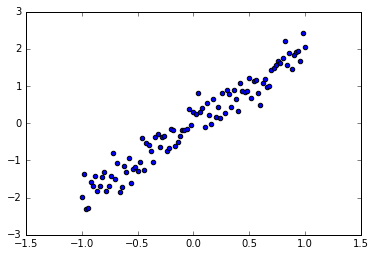

In [9]:
%matplotlib inline
x_batch = np.linspace(-1, 1, 101)
print x_batch
print x_batch.shape
y_batch = x_batch * 2 + np.random.randn(*x_batch.shape) * 0.3
plt.scatter(x_batch, y_batch)

We can initialize input Ops using the placeholder function

In [10]:
x = tf.placeholder(tf.float32, shape=(None,), name="x")
y = tf.placeholder(tf.float32, shape=(None,), name="y")

We also create a variable for the weights and note that a NumPy array is convertible to a Tensor.

In [11]:
w = tf.Variable(np.random.normal(), name="W")

Our approach here is to perform gradient descent to update a predictor, y_pred, using the least squares cost function.  Updating y_pred is simply done through a matrix multiplication similar to what we have performed earlier.

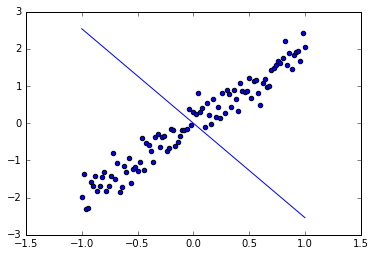

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
y_pred = tf.mul(w, x)
y0 = sess.run(y_pred, {x: x_batch})
#multiply by x for x in xbatch
plt.figure(1)
plt.scatter(x_batch, y_batch)
plt.plot(x_batch, y0)

cost = tf.reduce_mean(tf.square(y_pred - y))
summary_op = tf.scalar_summary("cost", cost)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train_op = optimizer.minimize(cost)

The initial predictor has little relation to the data.

We've selected the optimizer to reduce the cost function, which is the sum of squared differences with the data.  We can then define a Summary Writer which will output logs and enable visualizations in TensorBoard. 

We start our optimizer:

7.02269
6.11042
5.31799
4.62967
4.03178
3.51243
3.06132
2.66947
2.3291
2.03345
1.77664
1.55357
1.3598
1.19149
1.04529
0.918302
0.807995
0.712179
0.628951
0.556658
0.493862
0.439316
0.391936
0.35078
0.315032
0.28398
0.257007
0.233578
0.213227
0.195549


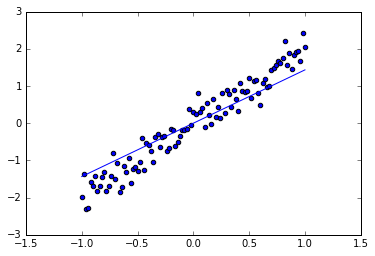

In [13]:
summary_writer = tf.train.SummaryWriter(logdir, sess.graph_def)
# if you want this to be part of tensorboard need to define a summary writer
for t in range(30):
    cost_t, summary, _ = sess.run([cost, summary_op, train_op], {x: x_batch, y: y_batch})
    summary_writer.add_summary(summary, t)
    print cost_t.mean()

y_pred_batch = sess.run(y_pred, {x: x_batch})  
plt.figure(1)
plt.scatter(x_batch, y_batch)
plt.plot(x_batch, y_pred_batch)

In [14]:
# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

tmp_def = rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

Check you're able to navigate around TensorBoard and navigate to the items below visualizing the graph, weights, and gradient descent parameters.

![TensorBoard graph](tensorboard1.png)


![TensorBoard weights](tensorboard2.png)


![TensorBoard gradient descent](tensorboard3.png)

# Multilayer Convolutional Network

In the following section, we use convolutional layers, a crucial tool in networks providing advances over traditional image recognition techniques on large datasets.  Here, we work with a dataset consisting of handwritten integers, the MNIST dataset.  

We use a class that stores the MNIST training, validation, and test sets as NumPy arrays.

We first initialize the weights and biases.  Weights are typically set to a low noise-like background to avoid 0 gradients providing a small perturbation to the start of optimization.

In [15]:
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


We may now define a helper function calling the convolution with a stride of one and zero padded to match the input and output size and standard 2x2 max pooling layers.  Under the hood, the TensorFlow functions use the NVIDIA cuDNN (CUDA Deep Neural Network) library to perform assembly optimized implementations on the GPU.

In [16]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

The structure of our network will be two sets of convolutional and pooling layers, followed by a fully connected layer, regularization layer, and softmax layer. The softmax layer generates probabilities assigned to each class.

In [17]:
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

The above specifies the convolutional and pooling layers.

In [18]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

We apply a Dropout layer, which undersamples the neurons during training to regularize (reduce overfitting) of our model.

We now train our model using the similar cross entropy as the objective function and the more robust Adam optimizer. The output is logged for every 100th iteration in the training process.

In [19]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.initialize_all_variables())
for i in range(6000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print "step %d, training accuracy %g"%(i, train_accuracy)
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print "test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})

step 0, training accuracy 0.12
step 100, training accuracy 0.86
step 200, training accuracy 0.9
step 300, training accuracy 0.82
step 400, training accuracy 0.96
step 500, training accuracy 0.92
step 600, training accuracy 1
step 700, training accuracy 0.98
step 800, training accuracy 0.88
step 900, training accuracy 1
step 1000, training accuracy 0.96
step 1100, training accuracy 0.94
step 1200, training accuracy 1
step 1300, training accuracy 0.98
step 1400, training accuracy 1
step 1500, training accuracy 0.98
step 1600, training accuracy 0.96
step 1700, training accuracy 0.96
step 1800, training accuracy 0.94
step 1900, training accuracy 0.98
step 2000, training accuracy 0.96
step 2100, training accuracy 0.96
step 2200, training accuracy 1
step 2300, training accuracy 1
step 2400, training accuracy 0.98
step 2500, training accuracy 1
step 2600, training accuracy 0.96
step 2700, training accuracy 1
step 2800, training accuracy 1
step 2900, training accuracy 1
step 3000, training acc

In [20]:

tmp_def = rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

The optimizer has converged on a reasonable solution with a final test accuracy over 99%.

## Sequence Autoencoder
In the next example, we demonstrate an autoencoder which learns a lower-dimensional representation of sequential input data.

In [21]:
sess.close()
ops.reset_default_graph()
from tensorflow.models.rnn import rnn_cell, seq2seq
sess = tf.InteractiveSession()
seq_length = 5
batch_size = 64

vocab_size = 7
embedding_dim = 50

memory_dim = 100

For each time point, we define an associated Tensor and label.  Finally, a weights constant is invariant with respect to time.

In [23]:
enc_inp = [tf.placeholder(tf.int32, shape=(None,),
                          name="inp%i" % t)
           for t in range(seq_length)]

labels = [tf.placeholder(tf.int32, shape=(None,),
                        name="labels%i" % t)
          for t in range(seq_length)]

weights = [tf.ones_like(labels_t, dtype=tf.float32)
           for labels_t in labels]

dec_inp = ([tf.zeros_like(enc_inp[0], dtype=np.int32, name="GO")]
           + enc_inp[:-1])

prev_mem = tf.zeros((batch_size, memory_dim))

We have defined a decoder input with the name "GO" and dropped the final value of the encoder. We now initialize the seq2seq embedding structure with the previously defined values and apply a loss function that is the cross-entropy across each item in the sequence.

In [24]:
cell = rnn_cell.GRUCell(memory_dim)
dec_outputs, dec_memory = seq2seq.embedding_rnn_seq2seq(enc_inp, dec_inp, cell, vocab_size, vocab_size)
#creates an rnn that knows that the target for the output is the next character in the sequence, dec_input is the 
#operation which is initialised to 0's

loss = seq2seq.sequence_loss(dec_outputs, labels, weights, vocab_size)
#calculate the output loss

We specify the outputs during training as the loss and the magnitude of activations.

In [25]:
tf.scalar_summary("loss", loss)
magnitude = tf.sqrt(tf.reduce_sum(tf.square(dec_outputs[1])))

tf.scalar_summary("magnitude at t=1", magnitude)

summary_op = tf.merge_all_summaries()

logdir = '/home/ubuntu'
summary_writer = tf.train.SummaryWriter(logdir, sess.graph_def)

We specify the learning rate and momentum to our momentum operator.  

In [26]:
learning_rate = 0.05
momentum = 0.9
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
train_op = optimizer.minimize(loss)

What would happen if we tripled our learning rate and momentum? ([answer](#Answer-#1)).

We train in batches on the GPU.

In [ ]:
def train_batch(batch_size):
    X = [np.random.choice(vocab_size, size=(seq_length,), replace=False)
         for _ in range(batch_size)]
    Y = X[:]
    X = np.array(X).T
    Y = np.array(Y).T
    feed_dict = {enc_inp[t]: X[t] for t in range(seq_length)}
    feed_dict.update({labels[t]: Y[t] for t in range(seq_length)})
    _, loss_t, summary = sess.run([train_op, loss, summary_op], feed_dict)
    return loss_t, summary

with tf.device('/gpu:0'):
    sess.run(tf.initialize_all_variables())
    for t in range(500):
        loss_t, summary = train_batch(batch_size)
        summary_writer.add_summary(summary, t)

In [ ]:
summary_writer.flush()

We can now test our lower dimensional autoencoder by passing data through the embedding to determine if the similar input was recovered.

In [ ]:
X_batch = [np.random.choice(vocab_size, size=(seq_length,), replace=False)
           for _ in range(10)]
X_batch = np.array(X_batch).T

feed_dict = {enc_inp[t]: X_batch[t] for t in range(seq_length)}
dec_outputs_batch = sess.run(dec_outputs, feed_dict)

print(X_batch)

[logits_t.argmax(axis=1) for logits_t in dec_outputs_batch]

tmp_def = rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

At this point, we may return and implement the changes in learning rate and momemtum to inform us on question 1.


# Multi-GPU Computation

Now we explore multi-GPU use.  In this exercise, we compute a high degree exponential of two separate matrices and sum them.  The matrix multiplication can be performed in parallel.

In [ ]:
sess.close()
ops.reset_default_graph()
log_device_placement = True
n = 10
A = np.random.rand(1e4, 1e4).astype('float32')
B = np.random.rand(1e4, 1e4).astype('float32')

c1 = []
c2 = []

def matpow(M, n):
    if n < 1: #Abstract cases where n < 1
        return M
    else:
        return tf.matmul(M, matpow(M, n-1))

The matpow function simply calls the matrix multiplication repeatedly.  The single GPU computation is as follows.

In [ ]:
with tf.device('/gpu:0'):
    a = tf.constant(A)
    b = tf.constant(B)
    c1.append(matpow(a, n))
    c1.append(matpow(b, n))

with tf.device('/cpu:0'):
  sum = tf.add_n(c1) 

t1_1 = datetime.datetime.now()
with tf.Session(config=tf.ConfigProto(log_device_placement=log_device_placement)) as sess:
    sess.run(sum)
t2_1 = datetime.datetime.now()

The add_n function sums all the elements stored in the c1 graph. In this case performing our summation.  The datetime library allows the computation to be timed.

Now we perform the multi-GPU computation, computing A^n and B^n on separate GPUs.

In [ ]:
with tf.device('/gpu:0'):
    a = tf.constant(A)
    c2.append(matpow(a, n))

with tf.device('/gpu:1'):
    b = tf.constant(B)
    c2.append(matpow(b, n))

with tf.device('/cpu:0'):
  sum = tf.add_n(c2) 

t1_2 = datetime.datetime.now()
with tf.Session(config=tf.ConfigProto(log_device_placement=log_device_placement)) as sess:
    sess.run(sum)
t2_2 = datetime.datetime.now()

print "Single GPU computation time: " + str(t2_1-t1_1)
print "Multi GPU computation time: " + str(t2_2-t1_2)
tmp_def = rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

What is the effect of performing the summation on a GPU device? ([answer](#Answer-#2))

# Parallelism on GPUs

An advanced example is training on the CIFAR-10 image classification training set using multiple GPUS.  CIFAR-10 consists of 32x32 color images in ten categories including airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

![cifar](cifar_samples.png)

In order to train on multiple GPUs, the model is duplicated in it's own "tower", receiving it's own data to be processed on the GPU.  The following section covers updating variables among multiple GPUs.  

In [ ]:
# Initialization and import of basic model parameters
# pylint: disable=missing-docstring
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import gzip
import os
import os.path
import re
import sys
import tarfile
from datetime import datetime
import time
import numpy as np
from six.moves import urllib
from six.moves import xrange
from tensorflow.models.image.cifar10 import cifar10_input
FLAGS = tf.app.flags.FLAGS

We declare constants and hyperparameters. Some constants describe the training process. Op names with the tower name differentiate the operations on GPUs. Note this prefix is removed when visualizing a model.

In [ ]:
DATA_URL = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'
IMAGE_SIZE = cifar10_input.IMAGE_SIZE
NUM_CLASSES = cifar10_input.NUM_CLASSES
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = cifar10_input.NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = cifar10_input.NUM_EXAMPLES_PER_EPOCH_FOR_EVAL
MOVING_AVERAGE_DECAY = 0.9999     # The decay to use for the moving average.
NUM_EPOCHS_PER_DECAY = 350.0      # Epochs after which learning rate decays.
LEARNING_RATE_DECAY_FACTOR = 0.1  # Learning rate decay factor.
INITIAL_LEARNING_RATE = 0.1       # Initial learning rate.
TOWER_NAME = 'tower'

Helper functions are used to declare variables in the computation graph, define variables with weight decay, and facilitate data input. 

In [ ]:
def _activation_summary(x):
  """Helper to create summaries for activations.
  Creates a summary that provides a histogram of activations.
  Creates a summary that measure the sparsity of activations.
  Args:
    x: Tensor
  Returns:
    nothing
  """
  tensor_name = re.sub('%s_[0-9]*/' % TOWER_NAME, '', x.op.name)
  tf.histogram_summary(tensor_name + '/activations', x)
  tf.scalar_summary(tensor_name + '/sparsity', tf.nn.zero_fraction(x))

def _variable_on_cpu(name, shape, initializer):
  """Helper to create a Variable stored on CPU memory.
  Args:
    name: name of the variable
    shape: list of ints
    initializer: initializer for Variable
  Returns:
    Variable Tensor
  """
  with tf.device('/cpu:0'):
    var = tf.get_variable(name, shape, initializer=initializer)
  return var

def _variable_with_weight_decay(name, shape, stddev, wd):
  """Helper to create an initialized Variable with weight decay.
  Note that the Variable is initialized with a truncated normal distribution.
  A weight decay is added only if one is specified.
  Args:
    name: name of the variable
    shape: list of ints
    stddev: standard deviation of a truncated Gaussian
    wd: add L2Loss weight decay multiplied by this float. If None, weight
        decay is not added for this Variable.
  Returns:
    Variable Tensor
  """
  var = _variable_on_cpu(name, shape,
                         tf.truncated_normal_initializer(stddev=stddev))
  if wd:
    weight_decay = tf.mul(tf.nn.l2_loss(var), wd, name='weight_loss')
    tf.add_to_collection('losses', weight_decay)
  return var

def distorted_inputs():
  """Construct distorted input for CIFAR training using the Reader ops.
  Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
  Raises:
    ValueError: If no data_dir
  """
  if not FLAGS.data_dir:
    raise ValueError('Please supply a data_dir')
  data_dir = os.path.join(FLAGS.data_dir, 'cifar-10-batches-bin')
  return cifar10_input.distorted_inputs(data_dir=data_dir,
                                        batch_size=FLAGS.batch_size)

def inputs(eval_data):
  """Construct input for CIFAR evaluation using the Reader ops.
  Args:
    eval_data: bool, indicating if one should use the train or eval data set.
  Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
  Raises:
    ValueError: If no data_dir
  """
  if not FLAGS.data_dir:
    raise ValueError('Please supply a data_dir')
  data_dir = os.path.join(FLAGS.data_dir, 'cifar-10-batches-bin')
  return cifar10_input.inputs(eval_data=eval_data, data_dir=data_dir,
                              batch_size=FLAGS.batch_size)

def maybe_download_and_extract():
  """Download and extract the tarball from Alex Krizhevsky's website."""
  dest_directory = FLAGS.data_dir
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (filename,
          float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath,
                                             reporthook=_progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

Below, we define the network architecture.  The architecture consists of two alternating pooling, normalization layers, followed by two locally connected layers and then the softmax activation layer.

In [ ]:
def inference(images):
  """Build the CIFAR-10 model.
  Args:
    images: Images returned from distorted_inputs() or inputs().
  Returns:
    Logits.
  """
  # Instantiate all variables using tf.get_variable() instead of
  # tf.Variable() in order to share variables across multiple GPU training runs.
  
  with tf.variable_scope('conv1') as scope:
    kernel = _variable_with_weight_decay('weights', shape=[5, 5, 3, 64],
                                         stddev=1e-4, wd=0.0)
    conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
    biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
    bias = tf.nn.bias_add(conv, biases)
    conv1 = tf.nn.relu(bias, name=scope.name)
    _activation_summary(conv1)

  pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool1')

  norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm1')

  with tf.variable_scope('conv2') as scope:
    kernel = _variable_with_weight_decay('weights', shape=[5, 5, 64, 64],
                                         stddev=1e-4, wd=0.0)
    conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
    bias = tf.nn.bias_add(conv, biases)
    conv2 = tf.nn.relu(bias, name=scope.name)
    _activation_summary(conv2)

  norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm2')

  pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1],
                         strides=[1, 2, 2, 1], padding='SAME', name='pool2')

  # local3
  with tf.variable_scope('local3') as scope:
    # Move everything into depth so we can perform a single matrix multiply.
    dim = 1
    for d in pool2.get_shape()[1:].as_list():
      dim *= d
    reshape = tf.reshape(pool2, [FLAGS.batch_size, dim])

    weights = _variable_with_weight_decay('weights', shape=[dim, 384],
                                          stddev=0.04, wd=0.004)
    biases = _variable_on_cpu('biases', [384], tf.constant_initializer(0.1))
    local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)
    _activation_summary(local3)

  # local4
  with tf.variable_scope('local4') as scope:
    weights = _variable_with_weight_decay('weights', shape=[384, 192],
                                          stddev=0.04, wd=0.004)
    biases = _variable_on_cpu('biases', [192], tf.constant_initializer(0.1))
    local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name=scope.name)
    _activation_summary(local4)

  # softmax, i.e. softmax(WX + b)
  with tf.variable_scope('softmax_linear') as scope:
    weights = _variable_with_weight_decay('weights', [192, NUM_CLASSES],
                                          stddev=1/192.0, wd=0.0)
    biases = _variable_on_cpu('biases', [NUM_CLASSES],
                              tf.constant_initializer(0.0))
    softmax_linear = tf.add(tf.matmul(local4, weights), biases, name=scope.name)
    _activation_summary(softmax_linear)

  return softmax_linear

We define the loss function here as the L2 norm of the weights and the cross entropy loss.

In [ ]:
def loss(logits, labels):
  """Add L2Loss to all the trainable variables.
  Add summary for for "Loss" and "Loss/avg".
  Args:
    logits: Logits from inference().
    labels: Labels from distorted_inputs or inputs(). 1-D tensor
            of shape [batch_size]
  Returns:
    Loss tensor of type float.
  """
  # Calculate the average cross entropy loss across the batch.
  labels = tf.cast(labels, tf.int64)
  cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits, labels, name='cross_entropy_per_example')
  cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
  tf.add_to_collection('losses', cross_entropy_mean)

  # The total loss is defined as the cross entropy loss plus all of the weight
  # decay terms (L2 loss).
  return tf.add_n(tf.get_collection('losses'), name='total_loss')

def _add_loss_summaries(total_loss):
  """Add summaries for losses in CIFAR-10 model.
  Generates moving average for all losses and associated summaries for
  visualizing the performance of the network.
  Args:
    total_loss: Total loss from loss().
  Returns:
    loss_averages_op: op for generating moving averages of losses.
  """
  # Compute the moving average of all individual losses and the total loss.
  loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
  losses = tf.get_collection('losses')
  loss_averages_op = loss_averages.apply(losses + [total_loss])

  # Attach a scalar summary to all individual losses and the total loss; do the
  # same for the averaged version of the losses.
  for l in losses + [total_loss]:
    # Name each loss as '(raw)' and name the moving average version of the loss
    # as the original loss name.
    tf.scalar_summary(l.op.name +' (raw)', l)
    tf.scalar_summary(l.op.name, loss_averages.average(l))

  return loss_averages_op

Now we set multi-GPU training building on the base model across towers. 

In [ ]:
FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string('train_dir', '/tmp/cifar10_train',
                           """Directory where to write event logs """
                           """and checkpoint.""")
tf.app.flags.DEFINE_integer('max_steps', 1000000,
                            """Number of batches to run.""")
tf.app.flags.DEFINE_integer('num_gpus', 4,
                            """How many GPUs to use.""")
tf.app.flags.DEFINE_boolean('log_device_placement', False,
                            """Whether to log device placement.""")
def tower_loss(scope):
  """Calculate the total loss on a single tower running the CIFAR model.
  Args:
    scope: unique prefix string identifying the CIFAR tower, e.g. 'tower_0'
  Returns:
     Tensor of shape [] containing the total loss for a batch of data
  """
  # Get images and labels for CIFAR-10.
  images, labels = distorted_inputs()

  # Build inference and loss Graph
  logits = inference(images)
  _ = loss(logits, labels)

  # Assemble all of the losses for the current tower only.
  losses = tf.get_collection('losses', scope)

  # Calculate the total loss for the current tower.
  total_loss = tf.add_n(losses, name='total_loss')

  # Compute the moving average of all individual losses and the total loss.
  loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
  loss_averages_op = loss_averages.apply(losses + [total_loss])

  # Attach a scalar summary to all individual losses and the total loss; do the
  # same for the averaged version of the losses.
  for l in losses + [total_loss]:
    loss_name = re.sub('%s_[0-9]*/' % TOWER_NAME, '', l.op.name)
    # Name each loss as '(raw)' and name the moving average version of the loss
    # as the original loss name.
    tf.scalar_summary(loss_name +' (raw)', l)
    tf.scalar_summary(loss_name, loss_averages.average(l))

  with tf.control_dependencies([loss_averages_op]):
    total_loss = tf.identity(total_loss)
  return total_loss

The multi-GPU approach taken here is through synchronous updates, meaning each model must finishes it's batch and then parameters are averaged across GPUs.

We may diagram out our computation graph with the assistance of Tensorboard.  The computation graph is illustrated below.

![tensorboardGPUs](modelParallelCifarGPU.png)

In [ ]:
def average_gradients(tower_grads):
  """Calculate the average gradient for each shared variable across all towers.
  Note that this function provides a synchronization point across all towers.
  Args:
    tower_grads: List of lists of (gradient, variable) tuples. The outer list
      is over individual gradients. The inner list is over the gradient
      calculation for each tower.
  Returns:
     List of pairs of (gradient, variable) where the gradient has been averaged
     across all towers.
  """
  average_grads = []
  for grad_and_vars in zip(*tower_grads):
    # Note that each grad_and_vars looks like the following:
    #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
    grads = []
    for g, _ in grad_and_vars:
      # Add 0 dimension to the gradients to represent the tower.
      expanded_g = tf.expand_dims(g, 0)

      # Append on a 'tower' dimension which we will average over below.
      grads.append(expanded_g)

    # Average over the 'tower' dimension.
    grad = tf.concat(0, grads)
    grad = tf.reduce_mean(grad, 0)

    # Keep in mind that the Variables are redundant because they are shared
    # across towers. So just return the first tower's pointer to the Variable.
    v = grad_and_vars[0][1]
    grad_and_var = (grad, v)
    average_grads.append(grad_and_var)
  return average_grads

def train():
  """Train CIFAR-10 for a number of steps."""
  with tf.Graph().as_default(), tf.device('/cpu:0'):
    # Create a variable to count the number of train() calls. This equals the
    # number of batches processed * FLAGS.num_gpus.
    global_step = tf.get_variable(
        'global_step', [],
        initializer=tf.constant_initializer(0), trainable=False)

    # Calculate the learning rate schedule.
    num_batches_per_epoch = (NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN /
                             FLAGS.batch_size)
    decay_steps = int(num_batches_per_epoch * NUM_EPOCHS_PER_DECAY)

    # Decay the learning rate exponentially based on the number of steps.
    lr = tf.train.exponential_decay(INITIAL_LEARNING_RATE,
                                    global_step,
                                    decay_steps,
                                    LEARNING_RATE_DECAY_FACTOR,
                                    staircase=True)

    # Create an optimizer that performs gradient descent.
    opt = tf.train.GradientDescentOptimizer(lr)

    # Calculate the gradients for each model tower.
    tower_grads = []
    for i in xrange(FLAGS.num_gpus):
      with tf.device('/gpu:%d' % i):
        with tf.name_scope('%s_%d' % (TOWER_NAME, i)) as scope:
          # Calculate the loss for one tower of the CIFAR model. This function
          # constructs the entire CIFAR model but shares the variables across
          # all towers.
          loss = tower_loss(scope)

          # Reuse variables for the next tower.
          tf.get_variable_scope().reuse_variables()

          # Retain the summaries from the final tower.
          summaries = tf.get_collection(tf.GraphKeys.SUMMARIES, scope)

          # Calculate the gradients for the batch of data on this CIFAR tower.
          grads = opt.compute_gradients(loss)

          # Keep track of the gradients across all towers.
          tower_grads.append(grads)

    # We must calculate the mean of each gradient. Note that this is the
    # synchronization point across all towers.
    grads = average_gradients(tower_grads)

    # Add a summary to track the learning rate.
    summaries.append(tf.scalar_summary('learning_rate', lr))

    # Add histograms for gradients.
    for grad, var in grads:
      if grad:
        summaries.append(
            tf.histogram_summary(var.op.name + '/gradients', grad))

    # Apply the gradients to adjust the shared variables.
    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

    # Add histograms for trainable variables.
    for var in tf.trainable_variables():
      summaries.append(tf.histogram_summary(var.op.name, var))

    # Track the moving averages of all trainable variables.
    variable_averages = tf.train.ExponentialMovingAverage(
        MOVING_AVERAGE_DECAY, global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())

    # Group all updates to into a single train op.
    train_op = tf.group(apply_gradient_op, variables_averages_op)

    # Create a saver.
    saver = tf.train.Saver(tf.all_variables())

    # Build the summary operation from the last tower summaries.
    summary_op = tf.merge_summary(summaries)

    # Build an initialization operation to run below.
    init = tf.initialize_all_variables()

    # Start running operations on the Graph. allow_soft_placement must be set to
    # True to build towers on GPU, as some of the ops do not have GPU
    # implementations.
    sess = tf.Session(config=tf.ConfigProto(
        allow_soft_placement=True,
        log_device_placement=FLAGS.log_device_placement))
    sess.run(init)

    # Start the queue runners.
    tf.train.start_queue_runners(sess=sess)

    summary_writer = tf.train.SummaryWriter(FLAGS.train_dir,
                                            graph_def=sess.graph_def)

    for step in xrange(FLAGS.max_steps):
      start_time = time.time()
      _, loss_value = sess.run([train_op, loss])
      duration = time.time() - start_time

      assert not np.isnan(loss_value), 'Model diverged with loss = NaN'

      if step % 10 == 0:
        num_examples_per_step = FLAGS.batch_size * FLAGS.num_gpus
        examples_per_sec = num_examples_per_step / duration
        sec_per_batch = duration / FLAGS.num_gpus

        format_str = ('%s: step %d, loss = %.2f (%.1f examples/sec; %.3f '
                      'sec/batch)')
        print (format_str % (datetime.now(), step, loss_value,
                             examples_per_sec, sec_per_batch))

      if step % 100 == 0:
        summary_str = sess.run(summary_op)
        summary_writer.add_summary(summary_str, step)

      # Save the model checkpoint periodically.
      if step % 1000 == 0 or (step + 1) == FLAGS.max_steps:
        checkpoint_path = os.path.join(FLAGS.train_dir, 'model.ckpt')
        saver.save(sess, checkpoint_path, global_step=step)

In [ ]:
#  Run the training
maybe_download_and_extract()
if tf.gfile.Exists(FLAGS.train_dir):
    tf.gfile.DeleteRecursively(FLAGS.train_dir)
    tf.gfile.MakeDirs(FLAGS.train_dir)
train()

What is the largest batch size that can be used?

# Distributed Training

In version 0.7.1 of TensorFlow, a [distributed runtime](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/core/distributed_runtime) was released which allows training to spread in a multi-node fashion.  The distributed runtime uses the Google Remote Procedure Call (gRPC) protocol to manage communication.  The [protocol](http://www.grpc.io/docs/) is an open-source, platform neutral method of communication. 

We first launch the gRPC server via commands on each node with an example below:

bazel-bin/tensorflow/core/distributed_runtime/rpc/grpc_tensorflow_server \
--cluster_spec='worker|192.168.170.193:2500;192.168.170.226:2501' --job_name=worker --task_id=0 &

The computation diagram would not appearas:

![tensorboardDistributed](modelParallelCifarDistributed.png)

We may now generalized multi-GPU example to multi-node as follows.

In [ ]:
sess.close()
ops.reset_default_graph()
n = 4
c1 = tf.Variable([])
c2 = tf.Variable([])
def matpow(M, n):
    if n < 1: #Abstract cases where n < 1
        return M
    else:
        return tf.matmul(M, matpow(M, n-1))

with tf.device("/job:worker/task:0/gpu:0"):
    A = np.random.rand(1e2, 1e2).astype('float32')
#     a = tf.constant(A)
    c1 = matpow(A,n)
    
with tf.device("/job:worker/task:1/gpu:1"):
    B = np.random.rand(1e2, 1e2).astype('float32')
#     b = tf.constant(B)
    c2 = matpow(B,n)
    
t1_3 = datetime.datetime.now()
with tf.Session("grpc://10.31.115.219:7777") as sess:
    # sess.run(sum)
    sum = c1 + c2
t2_3 = datetime.datetime.now()
print "Multi node computation time: " + str(t2_3-t1_3)   

tmp_def = rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

Here we are executing the matrix multiplies on separate nodes.  

The model parallelism approach generalizes well to distributed training.  For the fourth exercise, modify the CIFAR-10 code such that the execution is now model parallel.  

## Acknowledgements

Significant content borrowed from TensorFlow documentation [here](https://www.tensorflow.org/versions/0.6.0/tutorials/mnist/pros/index.html#build-a-multilayer-convolutional-network), and Aymeric Damien's repository [here](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/multigpu_basics.py). Original model parallel code is licensed under the Apache 2.0 license

## Post-Lab Summary

If you would like to download this lab for later viewing, it is recommend you go to your browsers File menu (not the Jupyter notebook file menu) and save the complete web page.  This will ensure the images are copied down as well.

## More information

For more information on using TensorFlow, visit https://www.tensorflow.org/versions/r0.7/tutorials/index.html. A description of the framework, how to use it, and plenty of examples similar to this lesson are posted. 

To learn more about these other topics, please visit:
* GPU accelerated machine learning: [http://www.nvidia.com/object/machine-learning.html](http://www.nvidia.com/object/machine-learning.html)
* Theano: [http://deeplearning.net/software/theano/](http://deeplearning.net/software/theano/)
* Torch: [http://torch.ch/](http://torch.ch/)
* DIGITS: [https://developer.nvidia.com/digits](https://developer.nvidia.com/digits)
* cuDNN: [https://developer.nvidia.com/cudnn](https://developer.nvidia.com/cudnn)

### Deep Learning Lab Series

Make sure to check out the rest of the classes in this Deep Learning lab series.  You can find them [here](https://developer.nvidia.com/deep-learning-courses).

### Answer #1

What would happen if we tripled our learning rate and momentum? 

Increasing the learning rate and momentum comes at the risks of skipping local minima.  Here, the learning rate and momentum results in a search that is too coarse and unable to converge.  Increasing momentum reduces the effect of the current time point compared to the previous time points.  This must be balanced with regards to the optimization landscape.  

### Answer #2

What is the effect of performing the summation on a GPU device?

The time is increased marginally.  The extra time stems from transferring data from two GPUs to one GPU (luckily the GPU memory is large enough to fit extra copies or otherwise the operation would fail).  There is a degree of parallelism that is exploited during matrix summations.


### Answer #3

What is the largest batch size that can be used?

The maximum batch size is 8192 for a 12 GB GPU, but diminishing returns are observed after 2048 batch size. 